<div style="text-align: right">NLP Research, Summer 2021</div>
<div style="text-align: right">Dino Konstantopoulos, 15 June 2021</div>

# Smart Linguistic Clusters

**Topic Models** are a type of statistical language models used for uncovering hidden structure in a collection of texts. More intuitively, you can think of it as a task of dimensionality Reduction, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}. It's like grouping ***movies*** into ***genres***, likr romance, science-fiction, etc.

Traditional NLP Clustering of corpora proceeds along a Bag-of-Words (BOW) model whereby is is assumed that words are generated from some **latent topics**. For example, in a world cuisine book, words about food stem from the `food` topic, while words about places stem from the `places` topic, and words about how to cook stem from the `cooking style` topic.

Our summer research idea is to improve on this model, and instead of **latent topics** that generate **words**, we posit **belief topics** that generate **whole sentences**. We plan on leveraging BERT sentence embeddings to help yield these beliefs. Nan and Chuanyang already accomplished a good amount of legwork with BERT embeddings. You have found some good beliefs and investigated dimensionality reduction ideas. Now we need to step back and adopt more structured approaches to converge on the beliefs in our documents. So let's go back to the root of BOW clustering methods -K-Means and LDA- to see how we can specialize them to BERT embeddings. This notebook is designed to help you ramp up to these methods.

To keep it simple, let's create NLP embeddings for each paragraph of Mao's works using `wordtovec` embeddings, which ought to theoretically takes care of the semantics, then average out the embedding for each word in a sentence to get a sentence embedding. I expect you to do better with BERT embeddings. Then, let's cluster the paragraphs into 4 clusters and see the most frequent words in the different clusters.

I harvested 6 of Mao's writings from [here](https://www.marxists.org/reference/archive/mao/selected-works/index.htm).

In [1]:
import os
for root, dirs, files in os.walk("c:/Users/Dino/mao"):
    for file in files:
        if file.endswith(".txt"):
             print(os.path.join(root, file))

c:/Users/Dino/mao\A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
c:/Users/Dino/mao\ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
c:/Users/Dino/mao\BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
c:/Users/Dino/mao\ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
c:/Users/Dino/mao\REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
c:/Users/Dino/mao\WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt


These are the paragraphs, and this is the first one below:

In [2]:
import os
mao_paragraphs = []
for root, dirs, files in os.walk("c:/Users/Dino/mao"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                paragraphs = input.read().split("\n\n")   #\n\n denotes there is a blank line in between paragraphs.
            #print(paragraphs[0])
            mao_paragraphs.extend(paragraphs)
            
print(len(mao_paragraphs))
print(mao_paragraphs[0])

c:/Users/Dino/mao\A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
c:/Users/Dino/mao\ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
c:/Users/Dino/mao\BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
c:/Users/Dino/mao\ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
c:/Users/Dino/mao\REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
c:/Users/Dino/mao\WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
202
Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take. Though they believe that a revolutionary high tide is inevitable, they do not believe it to be imminent. Therefore, they disapprove of the plan to take Kiangsi and only approve of roving guerrilla actions in the three areas on the borders of Fukien, Kwangtung and Kiangsi; at the same time, as they do not have a deep understanding of what it means to establish Red political power in t

We see that we have about 200 paragraphs and that the first paragraph is kind of looooooooooooooooooooong. Also, Mao tends to write long sentences. So, let's stick to sentences instead:

In [3]:
import os
mao_sentences = []
for root, dirs, files in os.walk("c:/Users/Dino/mao"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                sentences = input.read().split(". ")   #. denotes end of sentence
            mao_sentences.extend(sentences)
            
print(len(mao_sentences))
print(mao_sentences[0])

c:/Users/Dino/mao\A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
c:/Users/Dino/mao\ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
c:/Users/Dino/mao\BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
c:/Users/Dino/mao\ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
c:/Users/Dino/mao\REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
c:/Users/Dino/mao\WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
966
Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take


So we have about 1,000 sentences. Let's do some exploratory data analysis (EDA) so that we have all the intuitions about what our sentences contain. Let’s create a column that contains the length of each sentence to get an idea about the average number of words used in a sentence.

In [4]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

mao_df = pd.DataFrame(mao_sentences, columns = ['Sentence'])
mao_df.head()

d:\Anaconda3.5.1\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Sentence
0,Some comrades in our Party still do not know h...
1,Though they believe that a revolutionary high ...
2,"Therefore, they disapprove of the plan to take..."
3,"They seem to think that, since the revolutiona..."
4,"Instead, they want to extend our political inf..."


Text(0.5, 1.0, 'Distribution of number of words in each sentence')

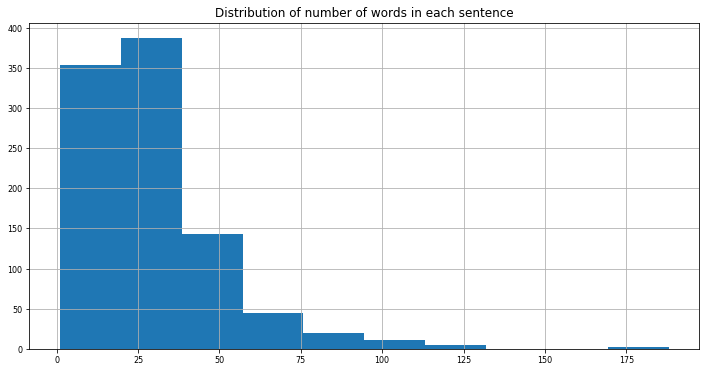

In [36]:
mao_df['NumWords'] = mao_df['Sentence'].apply(lambda x: len(x.split()))
mao_df[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distribution of number of words in each sentence")

Wow, 25 words on average! Now, let's build a word cloud to see the most frequent words. 

In [11]:
all_words = ''.join([word for word in mao_df['Sentence']]).replace('\n', ' ')
all_words[0:1000]

'Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to takeThough they believe that a revolutionary high tide is inevitable, they do not believe it to be imminentTherefore, they disapprove of the plan to take Kiangsi and only approve of roving guerrilla actions in the three areas on the borders of Fukien, Kwangtung and Kiangsi; at the same time, as they do not have a deep understanding of what it means to establish Red political power in the guerrilla areas, they do not have a deep understanding of the idea of accelerating the nation-wide revolutionary high tide through the consolidation and expansion of Red political powerThey seem to think that, since the revolutionary high tide is still remote, it will be labour lost to attempt to establish political power by hard workInstead, they want to extend our political influence through the easier method of roving guerrilla actions, and, once th

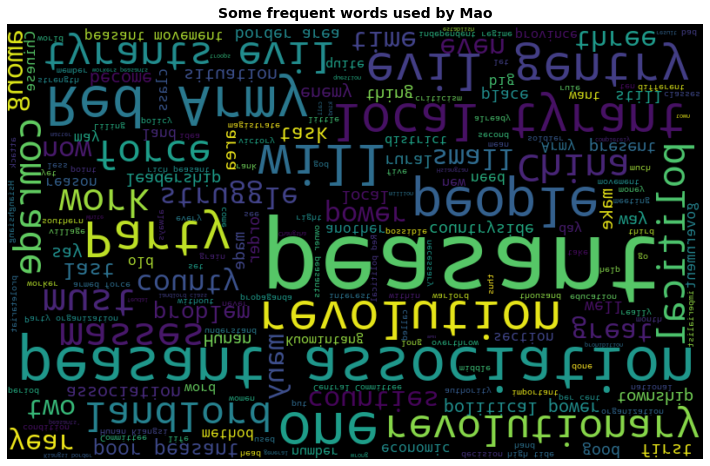

In [17]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear", origin='upper')
plt.axis('off')
plt.title("Some frequent words used by Mao", weight='bold', fontsize=14)
plt.savefig("data/maocloud.png", dpi=200)

I don't know why my anaconda mirror-flips my images :-(

In [18]:
from PIL import Image
from PIL import ImageOps

im = Image.open("data/maocloud.png")
im = ImageOps.mirror(im)
#im.save("lena_mirror.png")
im.show()

This works better:

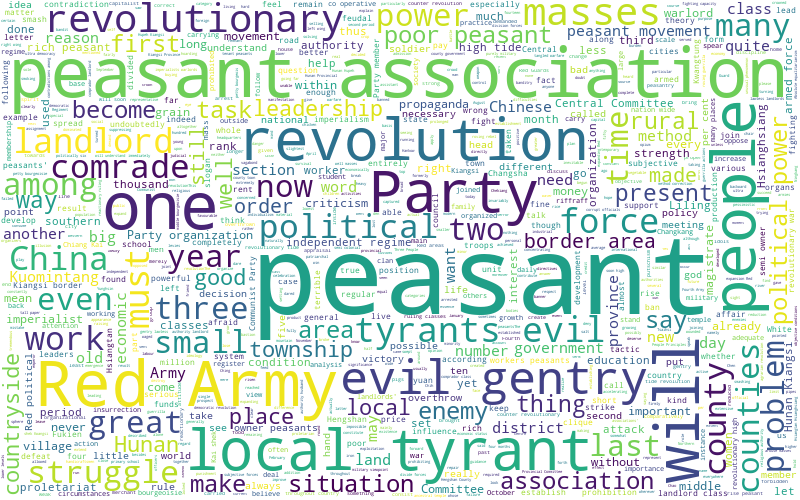

In [127]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500, max_font_size=110, background_color="white", max_words=3000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(all_words)

# Visualize the word cloud
wordcloud.to_image()

Let's do some cleaning operations like turning all words to lowercase, remove punctuation and non-ASCII characters which are irrelevant for modeling topics.

In [19]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
mao_df['Sentence2'] = mao_df['Sentence'].apply(normalize_texts)
mao_df.head()
mao_df['Sentence2'] = mao_df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

Top 30 words used with their frequencies:

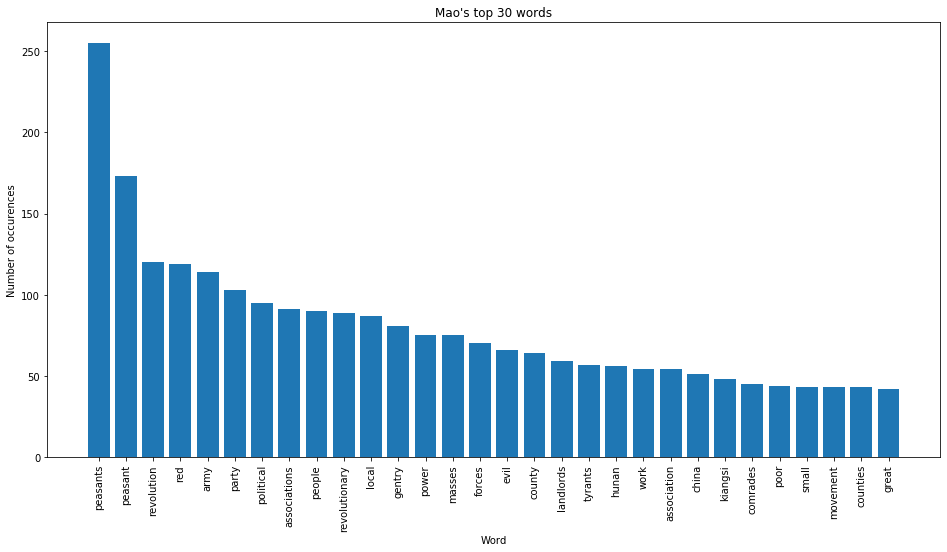

In [21]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(mao_df['Sentence2'], 30):
    words.append(i)
    word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("Mao's top 30 words");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Some interesting conclusions: We also need to **stem** words so that `peasants` and `peasant` represents the same occurrence. Also, some words needs to be grouped into bigrams, such as `red army`.

# 1. Word2vec embeddings

Let's import google's word embeddings from the pre-trained deep NN on google news and then represent each sentence with the mean of word embeddings for each word in that sentence.

You may want to:
```(python)
pip install --upgrade gensim
```
The cell below will take a good 5 minutes to run.

In [22]:
#importing wordtovec embeddings 
from gensim.models import KeyedVectors
pretrained_embeddings_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

Let's see how a word is represented in its embedding format:

In [23]:
word = 'peasant'
print('Word: {}'.format(word))
print('Dimesion of embedding:\n{}'.format(len(word2vec[word])))
print('First 20 values of embedding:\n{}'.format(word2vec[word][:20]))

Word: peasant
Dimesion of embedding:
300
First 20 values of embedding:
[ 0.28320312  0.04638672 -0.08789062  0.29492188  0.23046875  0.13085938
  0.20410156 -0.06347656  0.1875      0.02111816  0.06396484 -0.11816406
 -0.14355469  0.26367188 -0.1640625   0.28710938 -0.09326172  0.15039062
  0.06835938 -0.14160156]


In [24]:
word = 'king'
print('Word: {}'.format(word))
print('First 10 values of embedding:\n{}'.format(word2vec[word][:10]))

Word: king
First 10 values of embedding:
[ 0.12597656  0.02978516  0.00860596  0.13964844 -0.02563477 -0.03613281
  0.11181641 -0.19824219  0.05126953  0.36328125]


In [25]:
word = 'queen'
print('Word: {}'.format(word))
print('First 10 values of embedding:\n{}'.format(word2vec[word][:10]))

Word: queen
First 10 values of embedding:
[ 0.00524902 -0.14355469 -0.06933594  0.12353516  0.13183594 -0.08886719
 -0.07128906 -0.21679688 -0.19726562  0.05566406]


In [26]:
word = 'man'
print('Word: {}'.format(word))
print('First 10 values of embedding:\n{}'.format(word2vec[word][:10]))

Word: man
First 10 values of embedding:
[ 0.32617188  0.13085938  0.03466797 -0.08300781  0.08984375 -0.04125977
 -0.19824219  0.00689697  0.14355469  0.0019455 ]


In [27]:
word = 'woman'
print('Word: {}'.format(word))
print('First 10 values of embedding:\n{}'.format(word2vec[word][:10]))

Word: woman
First 10 values of embedding:
[ 0.24316406 -0.07714844 -0.10302734 -0.10742188  0.11816406 -0.10742188
 -0.11425781  0.02563477  0.11181641  0.04858398]


Here's the beauty of the word embeddings:

It captures **synonyms**, **antonyms** and all the logical analogies that we understand. If someone asks you what is `woman + king - man`, the first thing which comes to our mind will be `queen`. Now let’s see what **wordtovec** embeddings give as the most similar answers to this question.

In [28]:
print(word2vec.most_similar(positive=['woman', 'king'], negative=['man'], topn=3))

[('queen', 0.7118192911148071), ('monarch', 0.6189674139022827), ('princess', 0.5902431607246399)]


But this linear algebra is trained on google news, *not on Mao's writings*, for which we probably don't have enough text. 

However, we could take Google's embeddings and ***specialize*** them to Mao.

Now let's represent each sentence by the **mean** of word embeddings for each word in the sentence. We use the class `WordVecVectorizer` for this.

>**Note**: I'm not sure the **mean** is a good idea, but I want to start with something simpler *before* we move to sentence embeddings, because in Data Science, we always need a **baseline** to verify our results and prove that they make sense.

In [31]:
#mao_smaller = mao_df.sample(frac = 0.2, random_state= 423)
#mao_smaller.columns = ['Sentence2']

class WordVecVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X
        ])
    
wtv_vect = WordVecVectorizer(word2vec)
X_train_wtv = wtv_vect.transform(mao_df.Sentence)
print(X_train_wtv.shape)

(966, 300)


Before we try the k-Means algorithm, let's remember what we did in class.

# 2. LDA Clustering with PyCaret
Un class, we LDA-clustered Mao with 4 topics, using a paragraph-by-paragraph breakdown of our 6 Mao texts. Let's repeat with a sentence-by-sentence breakdown. We will go into more detail about what Latent Dirichlet Allocation (LDA) does in a later section.

Here’s the list of models that PyCaret currently supports:
- `lda`: Latent Dirichlet Allocation
- `lsi`: Latent Semantic Indexing
- `hdp`: Hierarchical Dirichlet Process
- `rp`: Random Projections
- `nmf`: Non-Negative Matrix Factorization

In [75]:
from pycaret.nlp import *

Pandas dataframe column:

In [71]:
mao_df.Sentence

0      Some comrades in our Party still do not know h...
1      Though they believe that a revolutionary high ...
2      Therefore, they disapprove of the plan to take...
3      They seem to think that, since the revolutiona...
4      Instead, they want to extend our political inf...
                             ...                        
961    An adequate solution of these economic problem...
962    THE PROBLEM OF MILITARY BASES\n\nThe Party in ...
963    The Five Wells mountain area at the juncture o...
964    The way to consolidate these bases is, first, ...
965    The Party in the border area must strive to pe...
Name: Sentence, Length: 966, dtype: object

Numpy array:

In [73]:
mao_sentences = mao_df.Sentence.values
mao_sentences[0:10]

array(['Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take',
       'Though they believe that a revolutionary high tide is inevitable, they do not believe it to be imminent',
       'Therefore, they disapprove of the plan to take Kiangsi and only approve of roving guerrilla actions in the three areas on the borders of Fukien, Kwangtung and Kiangsi; at the same time, as they do not have a deep understanding of what it means to establish Red political power in the guerrilla areas, they do not have a deep understanding of the idea of accelerating the nation-wide revolutionary high tide through the consolidation and expansion of Red political power',
       'They seem to think that, since the revolutionary high tide is still remote, it will be labour lost to attempt to establish political power by hard work',
       'Instead, they want to extend our political influence through the easi

Python array:

In [77]:
mao_sentences = mao_df.Sentence.values.tolist()
mao_sentences[0:10]

['Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take',
 'Though they believe that a revolutionary high tide is inevitable, they do not believe it to be imminent',
 'Therefore, they disapprove of the plan to take Kiangsi and only approve of roving guerrilla actions in the three areas on the borders of Fukien, Kwangtung and Kiangsi; at the same time, as they do not have a deep understanding of what it means to establish Red political power in the guerrilla areas, they do not have a deep understanding of the idea of accelerating the nation-wide revolutionary high tide through the consolidation and expansion of Red political power',
 'They seem to think that, since the revolutionary high tide is still remote, it will be labour lost to attempt to establish political power by hard work',
 'Instead, they want to extend our political influence through the easier method of roving guerrilla 

PyCaret requires python array input.

In [78]:
mao_100 = setup(data = mao_sentences, session_id = 123)

Description,Value
session_id,123
Documents,966
Vocab Size,2508
Custom Stopwords,False


In [80]:
lda = create_model('lda')

In [81]:
plot_model(lda, plot = 'topic_distribution')

The dominant topic (Topic 3) is about `peasants`, `people`, and `associations`. Topic 0 is about `politics` and `organization`. Topic 2 about the `economy` and `imperialism`. And Topic 1 about `revolution` and `war`.

In [82]:
plot_model(lda, plot = 'frequency', topic_num = 'Topic 0')

In [83]:
plot_model(lda, plot = 'frequency', topic_num = 'Topic 1')

In [84]:
plot_model(lda, plot = 'frequency', topic_num = 'Topic 2')

In [85]:
plot_model(lda, plot = 'frequency', topic_num = 'Topic 3')

In [86]:
lda_results = assign_model(lda)
lda_results.head()

,en,Topic_0,Topic_1,Topic_2,Topic_3,Dominant_Topic,Perc_Dominant_Topic
0,still know appraise current situation correctl...,0.285577,0.419431,0.131083,0.163908,Topic 1,0.42
1,inevitable believe imminent,0.459438,0.077281,0.101049,0.362232,Topic 0,0.46
2,therefore disapprove plan take approve rove gu...,0.110676,0.167593,0.019321,0.702410,Topic 3,0.70
3,seem think still remote labour lose attempt es...,0.070871,0.030890,0.591191,0.307048,Topic 2,0.59
4,instead want extend political influence easy m...,0.131165,0.017877,0.494422,0.356535,Topic 2,0.49


## Metrics

[Topic Coherence](https://www.aclweb.org/anthology/D12-1087.pdf) scores a single topic by measuring the degree of semantic similarity between high scoring words in the topic. 

These measurements help distinguish between topics that are *semantically interpretable*, and topics that are artifacts of statistical inference. 

The `tune_model()` function iterates on a pre-defined grid with a different number of topics and creates a model for each parameter. Topic coherence is then evaluated for different models and are visually presented in a graph the has `Coherence Score` on y-axis as a function of `# Topics` on x-axis:

In [87]:
tuned_unsupervised = tune_model(model = 'lda', multi_core = True)

IntProgress(value=0, description='Processing: ', max=25)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 300 | Coherence: 0.4978


The Model with the *highest* coherence score is the best model based on **intrinsic** evaluation criteria. 

8, 32, and 300 are the best number of topics. It's ***strange*** that with sentences, we get a different number of optimal topics versus paragraphs (we had gotten 4 with paragraphs in class).

As appealing as it may sound that performance of a topic model can be captured in one number i.e. Coherence Score, it doesn't come without its downside.

The other popular measure is [perplexity](https://en.wikipedia.org/wiki/Perplexity). Perplexity captures how ***surprised*** a model is of new data it has not seen before. It is also a good score for **chatbots**, and we will see this later in the semester.

Perplerxity is measured as the normalized log-likelihood of a held-out test set. You can think of the perplexity metric as measuring how probable some new unseen data is, given the model that was learned earlier. 

That is to say, how well does the model represent or reproduce the statistics of the held-out data. 

However, [recent studies](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0) have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. And so, optimizing for perplexity may not yield human interpretable topics.

We will now use pycaret's `tune_model()` function to determine the best number of topics. Best in this case will be defined by a standard measure of interest in supervised machine learning: **Accuracy**.

In [89]:
tuned_classification = tune_model(model = 'lda', multi_core = True)

IntProgress(value=0, description='Processing: ', max=25)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 300 | Coherence: 0.5033


In this example, `Accuracy` is optimized when `num_topics` are set to `300`, as well. 

The F1 score (also F-score or F-measure) is also a measure of a test's accuracy and calculated from the **precision** and **recall** of the test, where:
- precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly
- recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.

The F1 score is the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of the precision and recall. The highest possible value of F1 is 1, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero

It is very likely that the number of topics to optimize for a supervised metric such as accuracy is different than modeling with best coherence value.

## Attempt with paragraphs

I think the results above are very strange. 300 topics is too many. Let's try again with paragraphs instead of sentences!

In [128]:
len(mao_paragraphs), mao_paragraphs[0]

(202,
 "Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take. Though they believe that a revolutionary high tide is inevitable, they do not believe it to be imminent. Therefore, they disapprove of the plan to take Kiangsi and only approve of roving guerrilla actions in the three areas on the borders of Fukien, Kwangtung and Kiangsi; at the same time, as they do not have a deep understanding of what it means to establish Red political power in the guerrilla areas, they do not have a deep understanding of the idea of accelerating the nation-wide revolutionary high tide through the consolidation and expansion of Red political power. They seem to think that, since the revolutionary high tide is still remote, it will be labour lost to attempt to establish political power by hard work. Instead, they want to extend our political influence through the easier method of roving guerrilla action

In [129]:
mao_200 = setup(data = mao_paragraphs, session_id = 234)

Description,Value
session_id,234
Documents,202
Vocab Size,2506
Custom Stopwords,False


In [130]:
lda2 = create_model('lda')

In [131]:
plot_model(lda2, plot = 'topic_distribution')

The dominant topic appears with the same frist few keywords as with the previous attempt. The others, a bit different.

In [132]:
tuned_unsupervised = tune_model(model = 'lda', multi_core = True)

IntProgress(value=0, description='Processing: ', max=25)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 300 | Coherence: 0.4609


The same. Maybe I was wrong and remembered incorrectly about the 4 topics :-(

# 3. KMeans Clustering

So we have 966 sentences and each sentence has 300 features. These feature were obtained by averaging the google-news word embedding of each word in the sentence. 

We used our class `WordVecVectorizer` to get the google vectors from the words, and now we have our `mao_df.Sentence` sentences in the array `X_train_wtv`.

Let's use **KMeans** clustering to cluster them into 4 clusters.

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

A cluster refers to a collection of data points aggregated together because of certain similarities. You define a target number k, which refers to the number of centroids you need in the dataset (a centroid is the imaginary or real location representing the center of the cluster).

Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares. In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. The "*means*" in K-means refers to averaging of the data; that is, finding the centroid.

The algorithm bootstraps with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids. It halts creating and optimizing clusters when either the centroids have stabilized — there is no change in their values because clustering has been successful, or the defined number of iterations has been achieved.

We will use `scikit-learn`'s KMeans.

In [90]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X_train_wtv)
#df = pd.DataFrame({'mao': mao_df.Sentence, 'topic_cluster': y_km })
df = pd.DataFrame({'mao': mao_sentences, 'topic_cluster': y_km })

In [91]:
df.head()

,mao,topic_cluster
0,Some comrades in our Party still do not know h...,3
1,Though they believe that a revolutionary high ...,3
2,"Therefore, they disapprove of the plan to take...",3
3,"They seem to think that, since the revolutiona...",3
4,"Instead, they want to extend our political inf...",3


Let's visualize the top 10 words in each cluster and think about the topic they might represent:

In [92]:
df.loc[df['topic_cluster'] == 0].head()

,mao,topic_cluster
6,This theory derives mainly from the failure to...,0
17,Such an appraisal stems mainly from subjectivism,0
18,"In the end, it undoubtedly leads to putschism",0
32,[3] Such an appraisal necessarily led to putsc...,0
69,This is an unrealistic view,0


In [93]:
df.loc[df['topic_cluster'] == 0]['mao'].head()

6     This theory derives mainly from the failure to...
17     Such an appraisal stems mainly from subjectivism
18        In the end, it undoubtedly leads to putschism
32    [3] Such an appraisal necessarily led to putsc...
69                          This is an unrealistic view
Name: mao, dtype: object

In [94]:
df.loc[df['topic_cluster'] == 4]['mao'].head()

Series([], Name: mao, dtype: object)

## 1st Cluster Top 10

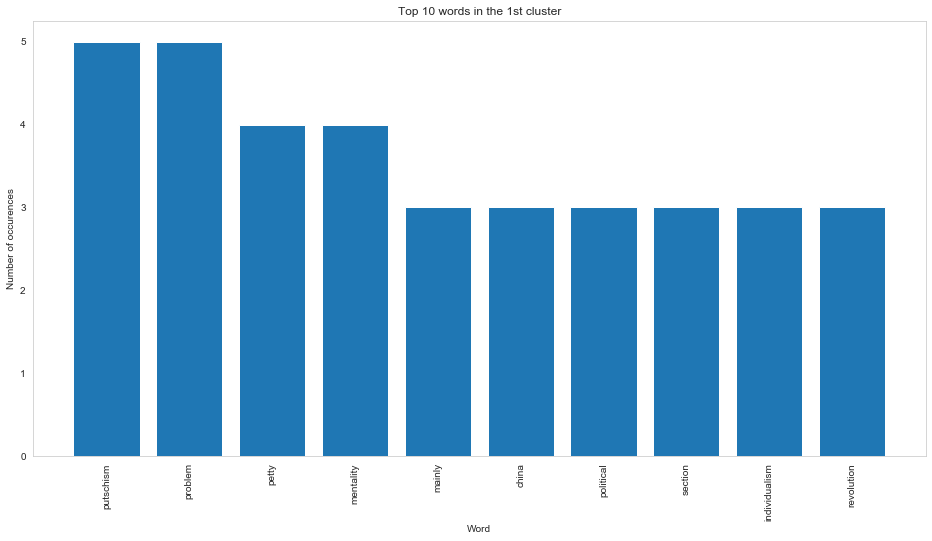

In [95]:
words = []
word_values = []
for i,j in get_top_n_words(df.loc[df['topic_cluster'] == 0]['mao'], 10):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 10 words in the 1st cluster');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

The first cluster appears to be about politics and revolution. Let's peek at the sentences it contains:

In [168]:
df.loc[df['topic_cluster'] == 0]['mao']

6      This theory derives mainly from the failure to...
17      Such an appraisal stems mainly from subjectivism
18         In the end, it undoubtedly leads to putschism
32     [3] Such an appraisal necessarily led to putsc...
69                           This is an unrealistic view
77                           This is a general principle
156    This section is a minority among the petty bou...
164    This section is very numerous, making up about...
173     The peasant problem is essentially their problem
198    It is not large because China is economically ...
204       The second reason is their low economic status
210    There is as yet little modern capitalist farmi...
237            There the situation is entirely different
267    That is the real iron bastion which no force c...
275    Unless the problem of method is solved, talk a...
290                 It manifests itself as follows:\n\n1
304           This is cliquism in a magnified form.\n\n7
307               This is a rem

The sentences pit the `peasant` versus the `landlord` and call for `revolution`.

## 2nd Cluster Top 10

The second cluster appears to be ill-conditioned, as it only contains a single word! Why?

In [166]:
df.loc[df['topic_cluster'] == 1]['mao']

370    Retaliation
Name: mao, dtype: object

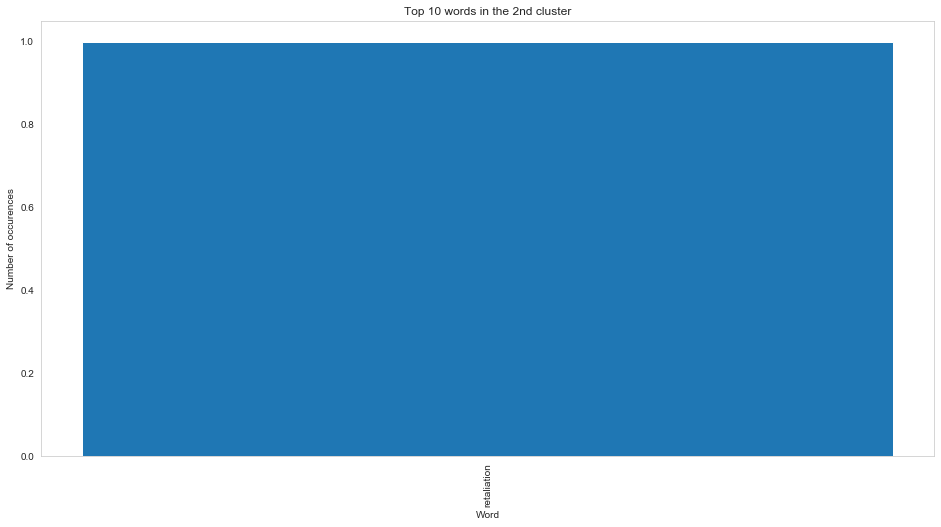

In [96]:
words = []
word_values = []
for i,j in get_top_n_words(df.loc[df['topic_cluster'] == 1]['mao'], 10):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 10 words in the 2nd cluster');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

## 3rd Cluster Top 10

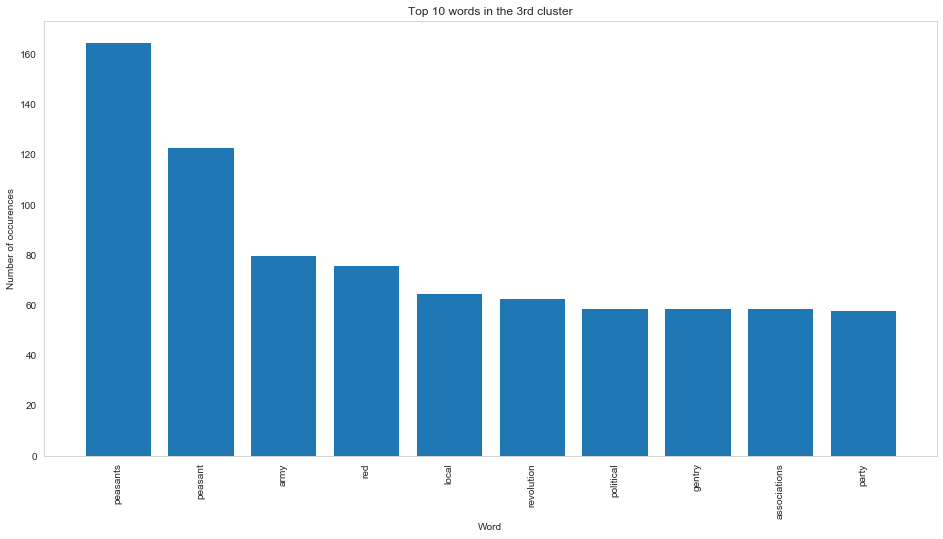

In [97]:
words = []
word_values = []
for i,j in get_top_n_words(df.loc[df['topic_cluster'] == 2]['mao'], 10):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 10 words in the 3rd cluster');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [169]:
df.loc[df['topic_cluster'] == 2]['mao']

8      Secondly, one will understand the gravity of t...
9      Thirdly, one will understand the correctness o...
10     Fourthly, one will understand another unusual ...
11     Fifthly, one will understand that in semi-colo...
12     And sixthly, one will also understand that the...
                             ...                        
957    The Red Army has to fight the enemy and to pro...
961    An adequate solution of these economic problem...
962    THE PROBLEM OF MILITARY BASES\n\nThe Party in ...
964    The way to consolidate these bases is, first, ...
965    The Party in the border area must strive to pe...
Name: mao, Length: 462, dtype: object

It seems to me that the 3rd cluster is about war.

## 4th Cluster Top 10

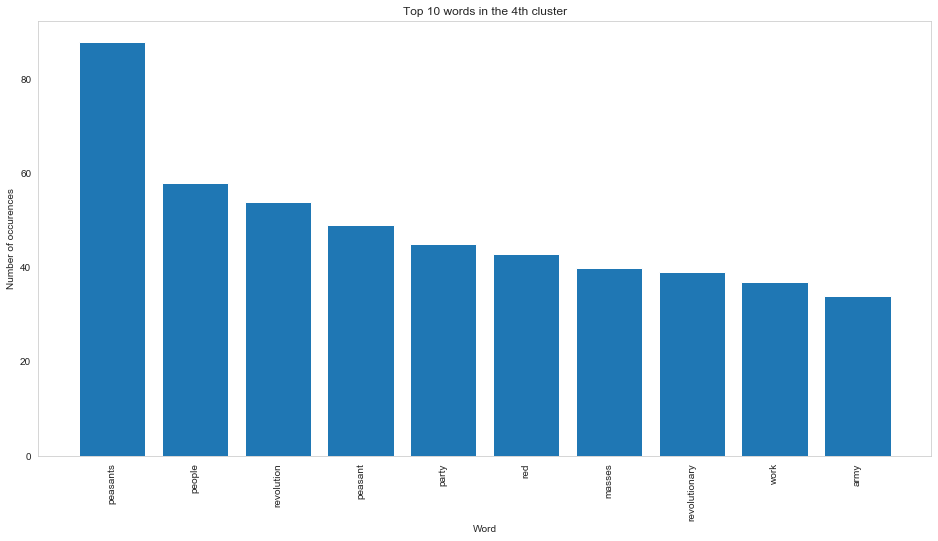

In [98]:
words = []
word_values = []
for i,j in get_top_n_words(df.loc[df['topic_cluster'] == 3]['mao'], 10):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 10 words in the 4th cluster');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [170]:
df.loc[df['topic_cluster'] == 3]['mao']

0      Some comrades in our Party still do not know h...
1      Though they believe that a revolutionary high ...
2      Therefore, they disapprove of the plan to take...
3      They seem to think that, since the revolutiona...
4      Instead, they want to extend our political inf...
                             ...                        
949    Although several times stronger than we, the e...
958    It even lacks funds to pay the daily food allo...
959    Such difficulties are of course unavoidable be...
960    Unless the Party in the border area can kind p...
963    The Five Wells mountain area at the juncture o...
Name: mao, Length: 454, dtype: object

I don't know hwo the 4th cluster is different from the first. Our clusters are unbalanced and somewaht undiferentiated. 4 may not be the right number of clusters, maybe we just don't have enough data for the algorithm, and also (probably) our word-embedding word-averaging technique is not very successful. The next step would be to use BERT sentence embeddings.

But before we go there, let's take a closer look at the LDA algorithm, which is the go-to method for topic clustering (preferred over KMeans).

# 4. LDA with scikit-learn

Let's use `scikit-learn`'s LDA implementation.

LDA is a probabilistic method to extract topics from document corpora. It assumes that each document is made up of several laten topics with a different probability distribution and each topic is made up of several words with a different distribution. So it works by initializing random words from each document into random topics and works in a reverse manner to discover the topics which would have generated the words in the documents. It starts by assuming a certain number of latent topics.

I told Chuanyang to use a TfIdf vectorizer, so I'll use one too, here. When we build our features using a TfIdf vectorizer,  similar to the bag-of-words (BOW) model except that TfIdf penalizes words which are present in many documents and emphasizes words unique to each document. 

These are our sentences:

In [99]:
len(mao_sentences), mao_sentences[0]

(966,
 'Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take')

In [100]:
sentences = [sentence.replace('\n', ' ') for sentence in mao_df['Sentence2']]
len(sentences), sentences[0]

(966,
 'some comrades our party still not know how appraise the current situation correctly and how settle the attendant question what action take')

These are all our words:

In [57]:
# [x for l in list for x in l] pattern
words = [word for sentence in mao_df['Sentence2'] for word in sentence.replace('\n', ' ').split(' ')]
print(words[0:10])

['some', 'comrades', 'our', 'party', 'still', 'not', 'know', 'how', 'appraise', 'the']


In [59]:
len(words)

23767

And this is a count of all *unique* words:

In [58]:
len(set(words))

3819

In `TfidfVectorizer`, the `max_features` parameter is optional and should be calibrated according to corpus.

If `max_features` is set to `None`, then the whole corpus is considered during the TF-IDF transformation. If you pass, say, 5 to `max_features`, that would mean creating a feature matrix out of the most 5 frequent words accross text documents.

Sometimes it is not effective to transform the whole vocabulary, as the data may have some rare words, which, if passed to TfidfVectorizer().fit(), will add unwanted dimensions to inputs in the future. One of the appropriate techniques in this case, would be to print out word frequences accross documents and then set a certain threshold for them. 

Imagine you have set a threshold of 50, and your data corpus consists of 100 words. After looking at the word frequences 20 words occur less than 50 times. Thus, you set max_features=80.

In our corpus, we have 3,800 words, so let's set the number of features to 3,000.

In [60]:
tf_vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
mao_matrix = tf_vectorizer.fit_transform(mao_df['Sentence2'])

#importing LDA
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation

#Fitting LDA
lda = LatentDirichletAllocation(n_components=4, learning_method='online', random_state=0, verbose=0, n_jobs = -1)
lda_model = lda.fit(mao_matrix)
lda_matrix = lda_model.transform(mao_matrix)
lda_matrix

array([[0.55981853, 0.06171393, 0.06185112, 0.31661643],
       [0.76867735, 0.07712183, 0.07710685, 0.07709397],
       [0.87222314, 0.04282634, 0.04251511, 0.04243541],
       ...,
       [0.87876837, 0.04031264, 0.04028999, 0.04062901],
       [0.84129431, 0.052911  , 0.05330777, 0.05248692],
       [0.77796725, 0.07400308, 0.07411465, 0.07391503]])

In [64]:
lda_matrix.shape

(966, 4)

Let's print the topics found by the LDA model:

In [62]:
def print_topics(model, count_vectorizer, n_top_words):
    words = tf_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
      
        print("\nTopic #%d:" % topic_idx )
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print("Topics found via LDA:")
print_topics(lda_model, mao_matrix, 10)

Topics found via LDA:

Topic #0:
peasants peasant red political army revolution revolutionary gentry local party

Topic #1:
imperialist china want majority bourgeois people struggles problems rule contradictions

Topic #2:
wrong result year peasants land live half taken party work

Topic #3:
peasants county peasant associations 000 banditry million revolution people landlords


### Topic Representation 

Theoretically, as we increase the size of our corpus, topics should become more ***specific*** and the model should extract more intelligently. 

Now, let's use [t-SNE](https://lvdmaaten.github.io/tsne/) to plot all sentences and color them by the topics they represent according to LDA. 

Though we know that each document comes from several topics, we will consider that for each document the topic with the highest probability is the topic that the document represents.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 966 samples in 0.047s...
[t-SNE] Computed neighbors for 966 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 966 / 966
[t-SNE] Mean sigma: 0.006463
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.773247
[t-SNE] KL divergence after 1000 iterations: 0.163307


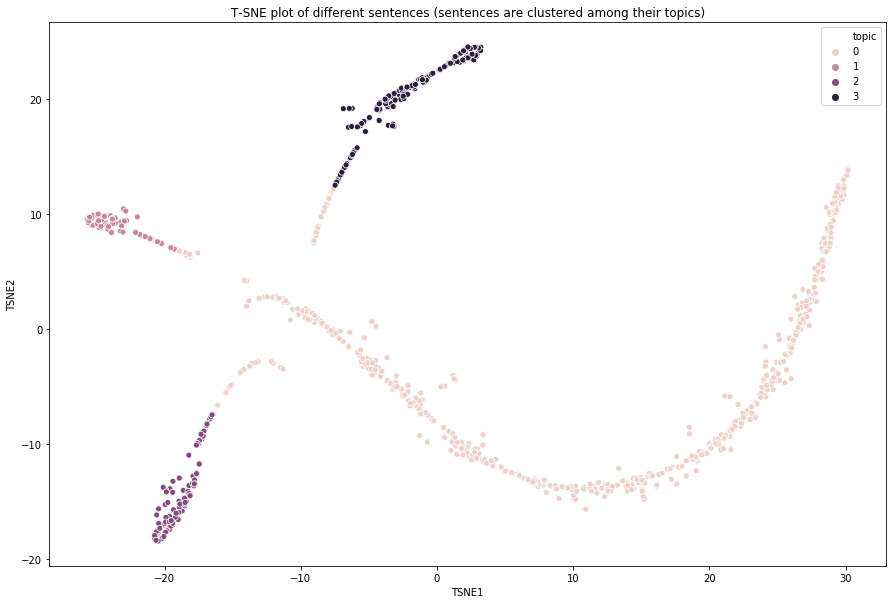

In [63]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=1000, verbose=1, random_state=0, angle=0.75)
tsne_features = model.fit_transform(lda_matrix)
df = pd.DataFrame(tsne_features)
df['topic'] = lda_matrix.argmax(axis=1)
df.columns = ['TSNE1', 'TSNE2', 'topic']

import seaborn as sns
plt.figure(figsize=(15, 10))
plt.title('T-SNE plot of different sentences (sentences are clustered among their topics)')
ax = sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'topic', data = df, legend = 'full')
plt.show()

The 2D t-SNE plot shows us that the topics separete quite well in 2D.

Let's try 3 dimensions, which is closer to our number of topics (4):

In [65]:
model3D = TSNE(n_components=3, perplexity=50, learning_rate=100, 
                        n_iter=1000, verbose=1, random_state=0, angle=0.75)
tsne_features_3D = model3D.fit_transform(lda_matrix)
df3D = pd.DataFrame(tsne_features_3D)
df3D['topic'] = lda_matrix.argmax(axis=1)
df3D.columns = ['TSNE1', 'TSNE2', 'TSNE3', 'topic']

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 966 samples in 0.001s...
[t-SNE] Computed neighbors for 966 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 966 / 966
[t-SNE] Mean sigma: 0.006463
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.256927
[t-SNE] KL divergence after 1000 iterations: 0.108082


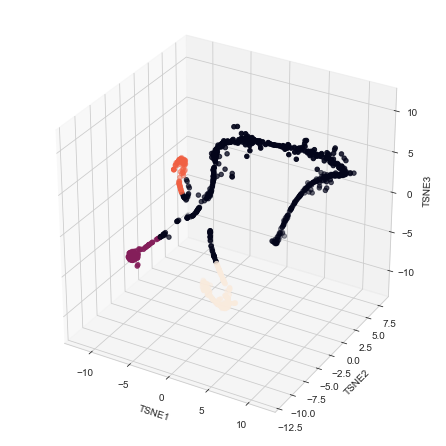

In [67]:
import re
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

ax.scatter(df3D['TSNE1'], df3D['TSNE2'], df3D['TSNE3'], c=df3D['topic'], marker='o')
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')

plt.show()

# 5. Deeper dive into LDA

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture f an underlying set of topics.

We can describe the generative process of LDA as, given the M number of documents, N number of words, and K number of topics, the model trains to output:
- $\psi$, the distribution of words for each topic k
- $\phi$, the distribution of topics for each document i

The parameters of LDA are:
- $\alpha$ parameter is the Dirichlet prior concentration parameter that represents document-topic density. With a higher alpha, documents are assumed to be made up of more topics. The more topics per document, the more specific a topic distribution per document.
- $\beta$ parameter is the Dirichlet prior concentration parameter that represents topic-word density. with a high beta, topics are made up of most of the words in the corpus, and with a low beta they consist of few words. Note that words can be shared across topics.

Also, there are **symmetric** and **asymmetric** LDA distributions. See [here](http://dirichlet.net/pdf/wallach09rethinking.pdf).

>**Note**: The probabilistic topic model estimated by LDA consists of two tables (matrices). The first table describes the probability of selecting a particular word when sampling a particular topic. The second table describes the probability of selecting a particular topic when sampling a particular document. For example, in the image below we have the words `bread`, `avocado`, and `bacon`, 3 latent topics, and 4 documents.

<br />
<left>
<img src="ipynb.images/lda-2-tables.png" width=900 />
</left>

<br />
In the animation below you see iterations of taking 1000 samples from a 3D (3 topics) Dirichlet distribution using an increasing $\alpha$ value:

<br />
<left>
<img src="ipynb.images/dirichlet.gif" width=600 />
</left>

The Dirichlet $\alpha$ could be different for each topicbut is usually set to be the same for all topics. Each dot in the figure above represents some distribution or mixture of three topics, like $(1.0, 0.0, 0.0)$ or $(0.4, 0.3, 0.3)$. All probabilities need to sum up to 1. 

At low $\alpha$ values (less than one), most of the topic distribution samples are in the corners (near the topics). For really low $\alpha$ values, it’s likely you’ll end up sampling $(1.0, 0.0, 0.0)$, $(0.0, 1.0, 0.0)$, or $(0.0, 0.0, 1.0)$. This would mean that a document would only ever have one topic, if we were building a three topic probabilistic topic model from scratch.

At $\alpha$ equal to one, any space on the surface of the triangle (or **2-simplex**) is fair game (in other words, uniformly distributed). You could equally likely end up with a sample favoring only one topic, a sample that gives an even mixture of all the topics, or something in between.

For $\alpha$ values greater than one, the samples start to congregate in the center of the triangle. This means that as alpha gets bigger, your samples will more likely be uniform — that is, represent an even mixture of all of the topics.

The $\alpha$ and $\beta$ hyperparameters are required by LDA. The $\alpha$ controls the mixture of topics for any given document. Turn it down, and the documents will likely have less of a mixture of topics. Turn it up, and the documents will likely have more of a mixture of topics.
The $\beta$ hyperparameter controls the distribution of words per topic. Turn it down, and the topics will likely have less words. Turn it up, and the topics will likely have more words.

Ideally, we want our documents to be made up of only a few topics and our words to belong to only some of the topics. With this in mind, $\alpha$ and $\beta$ are typically set below one.

### The algorithm
Here is a general description of the algorithm that I got from [here](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/):

So now suppose you have a set of documents. You’ve chosen some fixed number of K topics to discover, and want to use LDA to learn the topic representation of each document and the words associated to each topic. How do you do this? One way (known as collapsed Gibbs sampling) is the following:

Go through each document, and randomly assign each word in the document to one of the K topics.

Notice that this random assignment already gives you both topic representations of all the documents and word distributions of all the topics (albeit not very good ones).

So to improve on them, for each document d…

Go through each word w in d…

And for each topic t, compute two things:
- p(topic t | document d) = the proportion of words in document d that are currently assigned to topic t, and 
- p(word w | topic t) = the proportion of assignments to topic t over all documents that come from this word w. 

Reassign w a new topic, where we choose topic t with probability p(topic t | document d) * p(word w | topic t) (according to our generative model, this is essentially the probability that topic t generated word w, so it makes sense that we resample the current word’s topic with this probability). (Also, I’m glossing over a couple of things here, in particular the use of priors/pseudocounts in these probabilities).

In other words, in this step, we’re assuming that all topic assignments except for the current word in question are correct, and then updating the assignment of the current word using our model of how documents are generated.

After repeating the previous step a large number of times, you’ll eventually reach a roughly steady state where your assignments are pretty good. So use these assignments to estimate the topic mixtures of each document (by counting the proportion of words assigned to each topic within that document) and the words associated to each topic (by counting the proportion of words assigned to each topic overall).

Here's a [javascript](https://github.com/lettier/lda-topic-modeling) implementation of LDA (and the accompanying [description](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)), and here's a [python]() implementation.

**Stemming** is a text normalizing technique that cuts down affixes of words, to extract its base form or root words. Stemming is a crude process and sometimes, the root word, also called the stem, may not have grammatical meaning. In fact, in some other NLP libraries like spaCy, stemming is not included.

There are various stemming programs used to carry out stemming. These programs are called stemmer or stemming algorithm. In NLTK, there is the Porter Stemmer, Lancaster Stemmer, Regular Expression Stemmer, and Snowball Stemmer. The most common is the Porter stemming algorithm 

In [102]:
#import the PorterStemmer class from nltk.stem library
from nltk.stem import PorterStemmer

#insantiate the PorterStemmer class
stemmer = PorterStemmer()

#create a list of tokens
tokens = ['smiling', 'smile', 'smiled', 'smiles']

#create an empty list to take in the stemmed words
stemmed_words = []

#loop over each token in the list
for each_word in tokens:
    #stem each word in the list
    stemmed_word = stemmer.stem(each_word)
    
    #add the stemmed word to the empty stemmed word list
    stemmed_words.append(stemmed_word)
    
#print the stemmed words list
print(stemmed_words)

['smile', 'smile', 'smile', 'smile']


**Lemmatization** is almost like stemming, in that it cuts down affixes of words until a new word is formed. Only that in lemmatization, the root word, called ‘lemma’ is a word with a dictionary meaning. The morphological analysis of words is done in lemmatization, to remove inflection endings and outputs base words with dictionary meaning. Lemmatization with the NLTK library is done using the `WordNetLemmatizer` class.

In [106]:
#import the WordNetLemmatizer class from nltk.stem library
from nltk.stem import WordNetLemmatizer

#insantiate the WordNetLemmatizer class
lemmatizer = WordNetLemmatizer()

#create a list of tokens
tokens = ['crying', 'cry', 'cried']

#create an empty list to take in the lemmatized words
lemmatized_words = []

#loop over each token in the list
for each_word in tokens:
    #lemmatize each word in the list
    lemmatized_word = lemmatizer.lemmatize(each_word)
    
    #add the lemmatized word to the empty lemmatized word list
    lemmatized_words.append(lemmatized_word)
    
#print the lemmatized words list
print(lemmatized_words)

['cry', 'cry', 'cried']


In [103]:
sentence0 = mao_sentences[0]
sentence0

'Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take'

In [108]:
def my_stem(sentence):
    words = sentence.split(' ')
    stemmed_words = []

    for each_word in words:
        stemmed_word = stemmer.stem(each_word)
        stemmed_words.append(stemmed_word)
    
    return ' '.join(stemmed_words)

my_stem(sentence0)

'some comrad in our parti still do not know how to apprais the current situat correctli and how to settl the attend question of what action to take'

In [109]:
def my_lemm(sentence):
    words = sentence.split(' ')
    lemmed_words = []

    for each_word in words:
        lemmed_word = lemmatizer.lemmatize(each_word)
        lemmed_words.append(lemmed_word)
    
    return ' '.join(lemmed_words)

my_lemm(sentence0)

'Some comrade in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take'

We see that lemmatization is better than stemming. But lemmatization requires a solid understanding of linguistics, hence it is computationally intensive. If speed is a requirement, consider stemming. For example, if you are trying to build a sentiment analysis or an email classifier, the base word is sufficient to build your model. In this case, as well, go for stemming. However, if your model would actively interact with humans – say you are building a chatbot, language translation algorithm, etc, lemmatization would be a better option.

In [110]:
# Load the regular expression library
import re

# Remove punctuation
mao_df['Sentence3'] = \
mao_df['Sentence2'].map(lambda x: re.sub('[,\.!?]', '', x))

# lemmatize
mao_df['Sentence3'] = \
mao_df['Sentence3'].map(lambda x: my_lemm(x))

mao_df['Sentence3'].head()

0    some comrade our party still not know how appr...
1    though they believe that revolutionary high ti...
2    therefore they disapprove the plan take kiangs...
3    they seem think that since the revolutionary h...
4    instead they want extend our political influen...
Name: Sentence3, dtype: object

Although the lemmatizer seems to have removed stopwords, let's make sure:

In [111]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'use'])

simple_preprocess(sentence0)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['some',
 'comrades',
 'in',
 'our',
 'party',
 'still',
 'do',
 'not',
 'know',
 'how',
 'to',
 'appraise',
 'the',
 'current',
 'situation',
 'correctly',
 'and',
 'how',
 'to',
 'settle',
 'the',
 'attendant',
 'question',
 'of',
 'what',
 'action',
 'to',
 'take']

In [114]:
def remove_stopwords(text):
    return ' '.join([word for word in simple_preprocess(str(text)) if word not in stop_words])

mao_df['Sentence3'] = \
mao_df['Sentence3'].map(lambda x: remove_stopwords(x))

mao_df['Sentence3'].head()

0    comrade party still know appraise current situ...
1    though believe revolutionary high tide inevita...
2    therefore disapprove plan take kiangsi approve...
3    seem think since revolutionary high tide still...
4    instead want extend political influence easier...
Name: Sentence3, dtype: object

Better!

In the input format for `gensim`:

In [116]:
def remove_stopwords2(text):
    return [word for word in simple_preprocess(str(text)) if word not in stop_words]

mao_df['Sentence4'] = \
mao_df['Sentence3'].map(lambda x: remove_stopwords2(x))

mao_df['Sentence4'].head()

0    [comrade, party, still, know, appraise, curren...
1    [though, believe, revolutionary, high, tide, i...
2    [therefore, disapprove, plan, take, kiangsi, a...
3    [seem, think, since, revolutionary, high, tide...
4    [instead, want, extend, political, influence, ...
Name: Sentence4, dtype: object

In [118]:
mao_sentences2 = mao_df['Sentence4'].values.tolist()
mao_sentences2

[['comrade',
  'party',
  'still',
  'know',
  'appraise',
  'current',
  'situation',
  'correctly',
  'settle',
  'attendant',
  'question',
  'action',
  'take'],
 ['though',
  'believe',
  'revolutionary',
  'high',
  'tide',
  'inevitable',
  'believe',
  'imminent'],
 ['therefore',
  'disapprove',
  'plan',
  'take',
  'kiangsi',
  'approve',
  'roving',
  'guerrilla',
  'action',
  'three',
  'area',
  'border',
  'fukien',
  'kwangtung',
  'kiangsi',
  'time',
  'deep',
  'understanding',
  'mean',
  'establish',
  'red',
  'political',
  'power',
  'guerrilla',
  'area',
  'deep',
  'understanding',
  'idea',
  'accelerating',
  'nation',
  'wide',
  'revolutionary',
  'high',
  'tide',
  'consolidation',
  'expansion',
  'red',
  'political',
  'power'],
 ['seem',
  'think',
  'since',
  'revolutionary',
  'high',
  'tide',
  'still',
  'remote',
  'labour',
  'lost',
  'attempt',
  'establish',
  'political',
  'power',
  'hard',
  'work'],
 ['instead',
  'want',
  'extend',

In [122]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(mao_sentences2)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in mao_sentences2]

# View
print(corpus[0][0:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


Let's build a model with 4 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic:

In [123]:
from pprint import pprint

# number of topics
num_topics = 4

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print keywords in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"peasant" + 0.015*"association" + 0.008*"revolution" + 0.008*"county" '
  '+ 0.008*"wa" + 0.007*"army" + 0.007*"red" + 0.007*"revolutionary" + '
  '0.005*"hunan" + 0.005*"mass"'),
 (1,
  '0.020*"peasant" + 0.009*"power" + 0.007*"political" + 0.007*"ha" + '
  '0.007*"association" + 0.007*"party" + 0.006*"mass" + 0.006*"landlord" + '
  '0.005*"county" + 0.005*"red"'),
 (2,
  '0.025*"peasant" + 0.009*"gentry" + 0.008*"revolution" + 0.008*"local" + '
  '0.008*"force" + 0.007*"landlord" + 0.007*"revolutionary" + 0.007*"tyrant" + '
  '0.007*"evil" + 0.006*"ha"'),
 (3,
  '0.011*"peasant" + 0.009*"army" + 0.009*"party" + 0.009*"red" + 0.006*"one" '
  '+ 0.006*"people" + 0.006*"county" + 0.006*"enemy" + 0.006*"mass" + '
  '0.005*"political"')]


Let's visualize with `pyLDAvis`:

In [124]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

#LDAvis_data_filepath = os.path.join('data/results/ldavis_prepared_'+str(num_topics))
LDAvis_data_filepath = 'data/lda'

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, 'data/lda.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.052844  0.033446       1        1  28.108570
2     -0.023900 -0.049731       2        1  27.582163
3      0.039042 -0.026259       3        1  25.504801
1      0.037703  0.042544       4        1  18.804465, topic_info=             Term        Freq       Total Category  logprob  loglift
119       peasant  350.000000  350.000000  Default  30.0000  30.0000
1982  association  119.000000  119.000000  Default  29.0000  29.0000
315         enemy   34.000000   34.000000  Default  28.0000  28.0000
38          power   66.000000   66.000000  Default  27.0000  27.0000
1105       gentry   66.000000   66.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1109       tyrant    9.794233   52.246636   Topic4  -5.6613  -0.0031
71     revolution   12.647941   99.240867   Topic4  -5.4056  -0.3890
56           army   12.089291   98.539433   Topic4  -5.4508  -0.4271
103           one    9.707491   71.361171   Topic4  -5.6702  -0.3238
138         force    9.516276   72.158110   Topic4  -5.6901  -0.3548

[341 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2122      1  0.909477  accomplished
933       3  0.807984       achieve
2390      1  0.759120   achievement
2390      2  0.151824   achievement
2390      4  0.151824   achievement
...     ...       ...           ...
380       4  0.174447          year
1442      1  0.110568          yuan
1442      2  0.110568          yuan
1442      3  0.663410          yuan
1442      4  0.110568          yuan

[599 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

Let's try pycaret again with our lemmatized corpus:

In [133]:
mao_sentences3 = mao_df['Sentence3'].values.tolist()
mao_sentences3[0:10]

['comrade party still know appraise current situation correctly settle attendant question action take',
 'though believe revolutionary high tide inevitable believe imminent',
 'therefore disapprove plan take kiangsi approve roving guerrilla action three area border fukien kwangtung kiangsi time deep understanding mean establish red political power guerrilla area deep understanding idea accelerating nation wide revolutionary high tide consolidation expansion red political power',
 'seem think since revolutionary high tide still remote labour lost attempt establish political power hard work',
 'instead want extend political influence easier method roving guerrilla action mass throughout country le want launch nation wide armed insurrection participation red army would become great nationwide revolution',
 'theory must first win mass country wide scale region establish political power doe accord actual state chinese revolution',
 'theory derives mainly failure understand clearly china sem

In [134]:
mao_300 = setup(data = mao_sentences3, session_id = 345)

Description,Value
session_id,345
Documents,966
Vocab Size,2411
Custom Stopwords,False


In [135]:
lda3 = create_model('lda')

In [136]:
plot_model(lda3, plot = 'topic_distribution')

In [138]:
tuned_unsupervised = tune_model(model = 'lda', multi_core = True)

IntProgress(value=0, description='Processing: ', max=25)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 300 | Coherence: 0.5052


Still 300, but now 32 appears better than before (0.42 coherence instead of 0.34). Also, 2-topic coherence improved.

# 6. Simple LDA implementation
[Here](https://github.com/lda-project/lda)'s a python implementation on github. But it should not be very difficult, once you understand the algorithm, to code our own implementation. Let's code one that works with *both* the english and chinese version of Mao's texts.

Let's save the subdivision of our corpus into a file for easier processing. Let's pick a sentence-by-sentence breakdown. So we put each sentence into a single line of a file:

In [144]:
import codecs
file = codecs.open('data/mao_s.txt','w','utf-8')
    
for s in mao_sentences3:
    file.write(s + '\n')
    
file.close()    

First, let's build our dictionary and reverse dictionary so that we can work with numbers instead of words. Let's use `jieba` in a way that our code will work with both english and chinese texts:

In [145]:
import time
import jieba
import re

In [148]:
l = list(jieba.cut('comrade party still know appraise current situation correctly settle attendant question action take'))
l

['comrade',
 ' ',
 'party',
 ' ',
 'still',
 ' ',
 'know',
 ' ',
 'appraise',
 ' ',
 'current',
 ' ',
 'situation',
 ' ',
 'correctly',
 ' ',
 'settle',
 ' ',
 'attendant',
 ' ',
 'question',
 ' ',
 'action',
 ' ',
 'take']

In [153]:
def no_spaces(word):
    if 0 == len(word.strip()):
        return False
    else:
        return True
        
l2 = list(filter(no_spaces, l))
l2

['comrade',
 'party',
 'still',
 'know',
 'appraise',
 'current',
 'situation',
 'correctly',
 'settle',
 'attendant',
 'question',
 'action',
 'take']

In [154]:
' '.join(filter(no_spaces, l))

'comrade party still know appraise current situation correctly settle attendant question action take'

In [155]:
l3 = jieba.cut('党内同志尚知正视现状解决随之而来的问题采取行动')
' '.join(filter(no_spaces, l3))

'党内 同志 尚知 正视 现状 解决 随之而来 的 问题 采取行动'

In [156]:
def build_dictionaries():

    file = codecs.open('data/stopwords.dic','r','utf-8')
    stopwords = [line.strip() for line in file] 
    file.close()
    
    file = codecs.open('data/mao_s.txt','r','utf-8')
    documents = [document.strip() for document in file] 
    file.close()
    
    word2id = {}
    id2word = {}
    docs = []
    currentDocument = []
    currentWordId = 0
    
    for document in documents:

        segList = jieba.cut(document)
        for word in filter(no_spaces, segList): 
            word = word.lower().strip()
           
            if len(word) > 1 and not re.search('[0-9]', word) and word not in stopwords:
                if word in word2id:
                    currentDocument.append(word2id[word])
                else:
                    currentDocument.append(currentWordId)
                    word2id[word] = currentWordId
                    id2word[currentWordId] = word
                    currentWordId += 1
                    
        docs.append(currentDocument);
        currentDocument = []
        
    return docs, word2id, id2word

We sample with a multinomial distribution with equal probability for each topic:

In [157]:
def randomInitialize():
    for d, doc in enumerate(docs):
        zCurrentDoc = []
        for w in doc:
            pz = np.divide(np.multiply(ndz[d, :], nzw[:, w]), nz)
            z = np.random.multinomial(1, pz / pz.sum()).argmax()
            zCurrentDoc.append(z)
            ndz[d, z] += 1
            nzw[z, w] += 1
            nz[z] += 1
        Z.append(zCurrentDoc)

We resample topics for each word in each document:

In [158]:
def gibbsSampling():

    for d, doc in enumerate(docs):
        for index, w in enumerate(doc):
            z = Z[d][index]
            
            # Subtract 1 from the original topic related count of the current word in the current document
            ndz[d, z] -= 1
            nzw[z, w] -= 1
            nz[z] -= 1
            
            # Recalculate the probability that the current word of the current document belongs to each topic
            pz = np.divide(np.multiply(ndz[d, :], nzw[:, w]), nz)
            
            # Sample according to the calculated distribution
            z = np.random.multinomial(1, pz / pz.sum()).argmax()
            Z[d][index] = z
            
            # Add 1 to the topic related count newly sampled for the current word of the current document
            ndz[d, z] += 1
            nzw[z, w] += 1
            nz[z] += 1

Perplexity:

In [159]:
def perplexity():
    nd = np.sum(ndz, 1)
    n = 0
    ll = 0.0
    for d, doc in enumerate(docs):
        for w in doc:
            ll = ll + np.log(((nzw[:, w] / nz) * (ndz[d, :] / nd[d])).sum())
            n = n + 1
    return np.exp(ll/(-n))

Main loop:

In [160]:
docs, word2id, id2word = build_dictionaries()

In [164]:
alpha = 5
beta = 0.1
iterationNum = 300
Z = []
K = 4

N = len(docs)
M = len(word2id)
ndz = np.zeros([N, K]) + alpha
nzw = np.zeros([K, M]) + beta
nz = np.zeros([K]) + M * beta

randomInitialize()

for i in range(0, iterationNum):
    gibbsSampling()
    if i % 10 == 0:
        print(time.strftime('%X'), "Iteration: ", i, " Completed", " Perplexity: ", perplexity())

23:01:20 Iteration:  0  Completed  Perplexity:  1033.025829436164
23:01:25 Iteration:  10  Completed  Perplexity:  997.2997992054717
23:01:29 Iteration:  20  Completed  Perplexity:  971.495052882816
23:01:34 Iteration:  30  Completed  Perplexity:  957.1792921662548
23:01:38 Iteration:  40  Completed  Perplexity:  942.4749476236323
23:01:43 Iteration:  50  Completed  Perplexity:  935.5432909202258
23:01:47 Iteration:  60  Completed  Perplexity:  931.973619339338
23:01:51 Iteration:  70  Completed  Perplexity:  933.4863240203964
23:01:56 Iteration:  80  Completed  Perplexity:  929.5575807371034
23:02:00 Iteration:  90  Completed  Perplexity:  925.1675539199051
23:02:05 Iteration:  100  Completed  Perplexity:  918.9880926173654
23:02:09 Iteration:  110  Completed  Perplexity:  922.0390994616338
23:02:14 Iteration:  120  Completed  Perplexity:  912.1260377196041
23:02:18 Iteration:  130  Completed  Perplexity:  914.3701214585203
23:02:23 Iteration:  140  Completed  Perplexity:  910.2048448

In [165]:
topicwords = []
maxTopicWordsNum = 10
for z in range(0, K):
    ids = nzw[z, :].argsort()
    topicword = []
    for j in ids:
        topicword.insert(0, id2word[j])
    topicwords.append(topicword[0 : min(10, len(topicword))])
    
topicwords

[['revolution',
  'revolutionary',
  'wa',
  'class',
  'landlord',
  'china',
  'mass',
  'bourgeoisie',
  'warlord',
  'imperialist'],
 ['ha',
  'people',
  'local',
  'gentry',
  'evil',
  'tyrant',
  'countryside',
  'day',
  'town',
  'village'],
 ['peasant',
  'association',
  'county',
  'authority',
  'poor',
  'movement',
  'school',
  'land',
  'township',
  'grain'],
 ['army',
  'red',
  'party',
  'political',
  'force',
  'power',
  'hunan',
  'mass',
  'comrade',
  'kiangsi']]

Compare with 50 iterations:
```(python)
[['association',
  'county',
  'ha',
  'peasant',
  'day',
  'township',
  'district',
  'town',
  'land',
  'life'],
 ['peasant',
  'landlord',
  'people',
  'poor',
  'movement',
  'authority',
  'rich',
  'power',
  'grain',
  'middle'],
 ['revolution',
  'revolutionary',
  'wa',
  'gentry',
  'local',
  'evil',
  'tyrant',
  'class',
  'china',
  'comrade'],
 ['army',
  'red',
  'party',
  'political',
  'mass',
  'force',
  'hunan',
  'power',
  'struggle',
  'kiangsi']]
```

More iterations? How about decreasing $\alpha$?

# 7. K-Means with BERT embeddings

Recall that our K-Means clustering with word-averaged embeddings did not work very well. So, let's try again with BERT embeddings instead.

Running
```(python)
pip install -U sentence-transformers
```
will install `torch` and `torchvision`. Specifically, this is the list of packages installed: tokenizers, huggingface-hub, sacremoses, transformers, typing-extensions, torch, torchvision, sentencepiece, sentence-transformers. It should only take about a few minutes to install.

Released by Google in 2018. [BERT](https://arxiv.org/abs/1810.04805) achieved state-of-the-art results on a range of NLP tasks, relying on unannotated text drawn from the web as opposed to a language corpus that’s been labeled specifically for a given task. 

Facebook's [RoBERTa](https://arxiv.org/abs/1907.11692) builds on BERT’s language masking strategy, wherein the system learns to predict intentionally hidden sections of text within otherwise unannotated language examples. RoBERTa was implemented in PyTorch and modifies key hyperparameters in BERT. It also removes BERT’s next-sentence pretraining objective and trains with larger mini-batches and learning rates. Facebook conjectures that this allows RoBERTa to improve on the masked language modeling objective compared with BERT and leads to better downstream task performance. Faberook also trained RoBERTa on an order of magnitude more data than BERT, for a longer amount of time. Facebook used existing unannotated NLP datasets as well as CC-News, a novel set drawn from public news articles. When released, RoBERTa reached the top position on the GLUE leaderboard with a score of 88.5, matching the performance of the previous leader, XLNet-Large.

We leverage the `large` roberta model.

In [184]:
import torch
from packaging import version
from transformers.utils.versions import importlib_metadata
torch_version = version.parse(importlib_metadata.version("torch"))
torch_version

<Version('1.9.0')>

In [181]:
version.parse("1.8")

<Version('1.8')>

The cell below leads to an error on my anaconda installation, forcing me to do this mod on `D:\Anaconda3.5.1\Lib\site-packages\transformers\file_utils.py`:
```(python)
    # ~dk
    #_torch_fx_available = (torch_version.major, torch_version.minor) == (
    #    TORCH_FX_REQUIRED_VERSION.major,
    #    TORCH_FX_REQUIRED_VERSION.minor,
    #)
    _torch_fx_available = True
```
Then the import below works ok:

In [187]:
import transformers

The cell below will take a couple of minutes to run and will result in a 1.3G download of a pretrained model.

In [188]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('stsb-roberta-large')

Let's see how our lemmatization affects BERT sentence embeddings:

In [190]:
mao_sentences[0]

'Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take'

In [191]:
mao_sentences3[0]

'comrade party still know appraise current situation correctly settle attendant question action take'

In [192]:
original = model.encode(mao_sentences[0])
original

array([ 0.27242574,  0.721691  ,  0.24801196, ...,  1.1603777 ,
       -2.2897995 ,  1.7773807 ], dtype=float32)

In [193]:
original.shape

(1024,)

In [194]:
lemmatized = model.encode(mao_sentences[0])
lemmatized

array([ 0.27242574,  0.721691  ,  0.24801196, ...,  1.1603777 ,
       -2.2897995 ,  1.7773807 ], dtype=float32)

In [196]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([original], [lemmatized])

array([[1.]], dtype=float32)

A cosine of 1 implies an angle of 0. Interesting... Lemmatization seems to not affect sentence embeddings, so we can work with the original text :-)

In [198]:
sentence_first = model.encode(mao_sentences[0])
mao_sentences[0], sentence_first

('Some comrades in our Party still do not know how to appraise the current situation correctly and how to settle the attendant question of what action to take',
 array([ 0.27242574,  0.721691  ,  0.24801196, ...,  1.1603777 ,
        -2.2897995 ,  1.7773807 ], dtype=float32))

In [199]:
sentence_second = model.encode(mao_sentences[1])
mao_sentences[1], sentence_second

('Though they believe that a revolutionary high tide is inevitable, they do not believe it to be imminent',
 array([ 0.17519224,  1.0001767 ,  0.27246627, ...,  0.7610985 ,
        -0.1431073 ,  0.7442535 ], dtype=float32))

In [200]:
cosine_similarity([sentence_first], [sentence_second])

array([[0.35996282]], dtype=float32)

Let's encode all our Mao's sentences:

In [201]:
len(mao_sentences)

966

The cell below takes about 5 minutes to complete.

In [202]:
mao_1024 = model.encode(mao_sentences)

In [203]:
mao_1024.shape

(966, 1024)

In [204]:
mao_1024

array([[ 0.2724254 ,  0.7216908 ,  0.24801159, ...,  1.1603777 ,
        -2.2897992 ,  1.7773813 ],
       [ 0.1751911 ,  1.0001774 ,  0.27246583, ...,  0.761098  ,
        -0.14310697,  0.7442527 ],
       [-0.27378258,  1.0755044 ,  0.2996554 , ...,  0.43401417,
        -2.019106  ,  0.19552729],
       ...,
       [-0.5184836 , -0.35265344, -0.28291482, ...,  1.3682694 ,
        -1.74095   ,  0.14521538],
       [-0.34146225,  0.76448214, -0.68150854, ...,  1.124394  ,
        -0.27939272,  0.5319475 ],
       [ 0.5425847 ,  0.37349764, -0.5620403 , ..., -0.08666781,
        -1.2450166 ,  0.09091303]], dtype=float32)

Let's try 4 clusters...

In [205]:
km2 = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km2 = km2.fit_predict(mao_1024)
df2 = pd.DataFrame({'mao': mao_sentences, 'topic_cluster': y_km2 })
df2.head()

,mao,topic_cluster
0,Some comrades in our Party still do not know h...,1
1,Though they believe that a revolutionary high ...,2
2,"Therefore, they disapprove of the plan to take...",3
3,"They seem to think that, since the revolutiona...",3
4,"Instead, they want to extend our political inf...",2


## 1st Cluster

In [212]:
df2.loc[df2['topic_cluster'] == 0]['mao']

8      Secondly, one will understand the gravity of t...
9      Thirdly, one will understand the correctness o...
44     In the wake of imperialist commercial aggressi...
45     Because of the pressure of foreign goods, the ...
47     Because of the growth in government taxation, ...
                             ...                        
915    This is a new development.\n\nAccording to the...
923    Two things account for its occurrence, namely,...
928    In many parts of these provinces trade unions ...
929    This is why the people held political power fo...
953    THE ROLE OF THE INDEPENDENT REGIME OF THE HUNA...
Name: mao, Length: 281, dtype: object

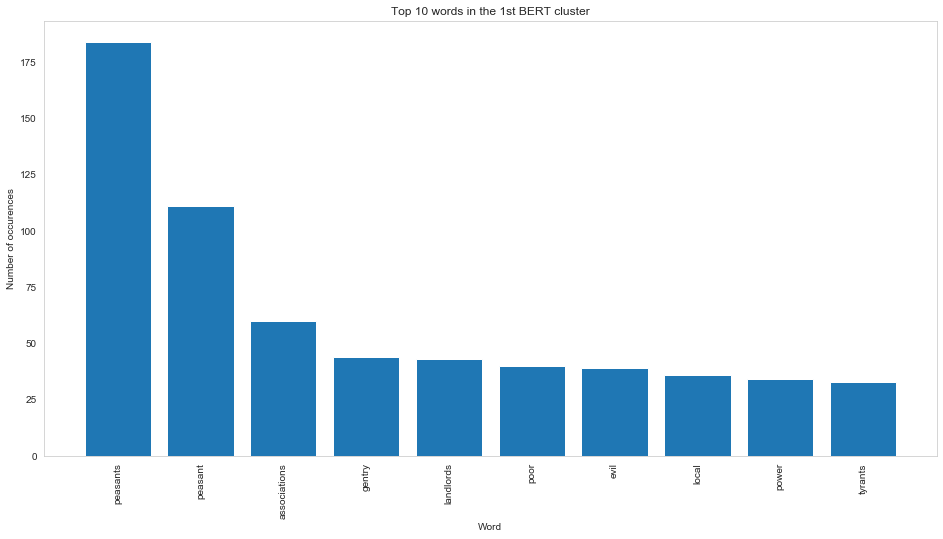

In [209]:
words = []
word_values = []
for i,j in get_top_n_words(df2.loc[df2['topic_cluster'] == 0]['mao'], 10):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 10 words in the 1st BERT cluster');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Pretty clear that the first cluster is about the struggle between `poor`/`peasants`/`peasant associations` and `evil`/`landlords`/`gentry`/`tyrants`.

# 2nd Cluster

In [211]:
df2.loc[df2['topic_cluster'] == 1]['mao']

0      Some comrades in our Party still do not know h...
17      Such an appraisal stems mainly from subjectivism
18         In the end, it undoubtedly leads to putschism
20     Therefore, in judging the political situation ...
26     But if we judge by essentials, it is quite ano...
                             ...                        
940    Thus opportunities are provided for the rise o...
947    This was possible because the policies of the ...
952    The situation arising from this defeat was sal...
961    An adequate solution of these economic problem...
965    The Party in the border area must strive to pe...
Name: mao, Length: 209, dtype: object

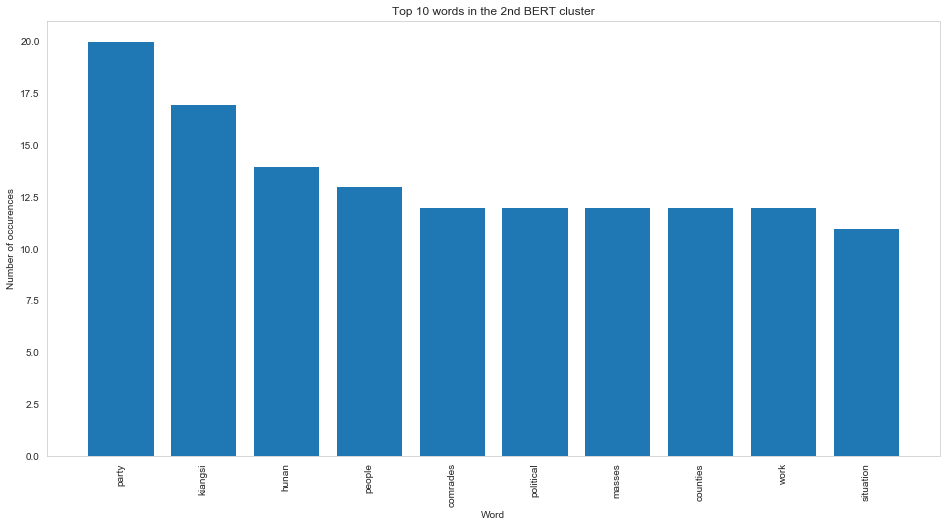

In [213]:
words = []
word_values = []
for i,j in get_top_n_words(df2.loc[df2['topic_cluster'] == 1]['mao'], 10):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 10 words in the 2nd BERT cluster');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

## 3rd Cluster

In [216]:
df2.loc[df2['topic_cluster'] == 2]['mao']

1      Though they believe that a revolutionary high ...
4      Instead, they want to extend our political inf...
5      Their theory that we must first win over the m...
7      If one clearly understands this, one will unde...
10     Fourthly, one will understand another unusual ...
                             ...                        
959    Such difficulties are of course unavoidable be...
960    Unless the Party in the border area can kind p...
962    THE PROBLEM OF MILITARY BASES\n\nThe Party in ...
963    The Five Wells mountain area at the juncture o...
964    The way to consolidate these bases is, first, ...
Name: mao, Length: 208, dtype: object

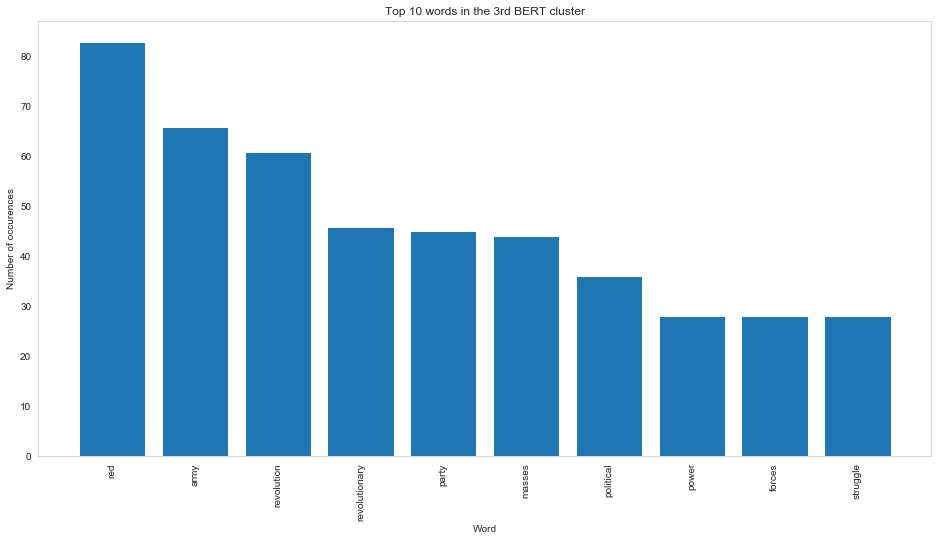

In [215]:
words = []
word_values = []
for i,j in get_top_n_words(df2.loc[df2['topic_cluster'] == 2]['mao'], 10):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 10 words in the 3rd BERT cluster');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

## 4th Cluster

In [217]:
df2.loc[df2['topic_cluster'] == 3]['mao']

2      Therefore, they disapprove of the plan to take...
3      They seem to think that, since the revolutiona...
6      This theory derives mainly from the failure to...
21     Although the subjective forces of the revoluti...
22     This helps to explain why revolution cannot br...
                             ...                        
936    If we have local Red Guards [9] only but no re...
941    But fighting among the warlords does not go on...
945    From April onward the independent regime in th...
950    The sole reason for the August defeat was that...
951    Comrade Tu Hsiu-ching, the representative of t...
Name: mao, Length: 268, dtype: object

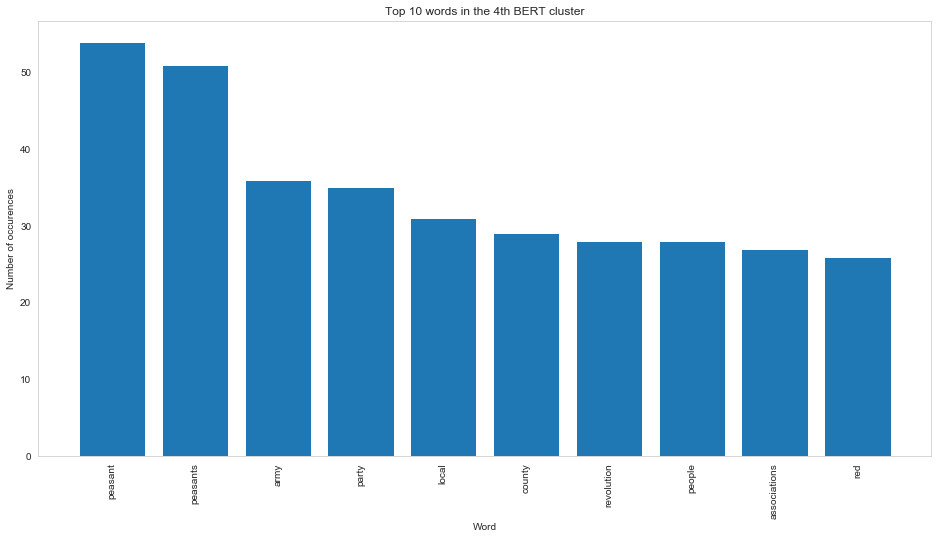

In [218]:
words = []
word_values = []
for i,j in get_top_n_words(df2.loc[df2['topic_cluster'] == 3]['mao'], 10):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 10 words in the 4th BERT cluster');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

It is clear that wour clusters are much better balanced than before, with about a fourth of the sentences in each. But I cannot see central beliefs emerge *yet* just form the top 10 words. We need a better analysis on the average word vector for each cluster, and we also need to find a way to do a search on *all* possible cluster numbers to find the one with the lowest perplexity.

We also need to confirm that `sentence-transformers` is the best package to use, and that `roberta-large` is the best model.

# 8. Conclusion

We are now very familiar with the two top methods (K-Means and LDA) to cluster the words of a document into topics. Our research goal is to cluster the **sentences** of a document into **belief topics**. These are some of our tasks:

- Preprocessing: Should we preprocess sentences into a POS decomposition, and just as we did with lemmatization and stopword removal, reduce our sentences into simple Subject - Verb - Object form before we compute the sentence embedding, just to extract the basic intent behind the sentence? Based on preliminary results where lemmatization did not make a difference, it may be that a POS decomposition may not help.
- Refine our K-Means cluster formations to find the optimal cluster number, then find a way (average?) to extract the central belief from each cluster. It's easy enough to obtain the average sentence embedding from each cluster, but how do we get the *english* sentence from the average embedding?
- It is clear how k-Means works with sentence embeddings, but how can we work with LDA and BERT embeddings instead? What do we plug into the Gibbs sampling procedure? LDA is generally considered superior to KMeans for linguistic clustering.